<h2><b><font color="#FFFFFF"> Doctor Who - Time Series. </font></b></h2>

In [35]:

#%pip install statsmodels
#%pip install scikit-learn
#%pip install sktime
#%pip install skforecast
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install seaborn
#%pip install pmdarima
#%pip install openpyxl




---

<a name="section_1"></a>
## 1. Import and Data Quality Checks

In [36]:
# data manipulation and analysis python packages
import pandas as pd
import numpy as np
import scipy

# plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# modelling and evaluation
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

#HTML formattin
from IPython.display import display, HTML


In [37]:
#import the data
df = pd.read_excel('C:\Pythonsss\Doctor_Who_Data_Final.xlsx')
df.head()

,Season,Episode,Episode ID,Episode Title,Written by,Release Date,Viewers,Year,IMDB Score,Doctor,Companion,Showrunner,Special Episode
0,1,1,101,Rose,Russell T Davies,2005-03-26,10.81,2005,7.5,9,Rose,Russell T Davies,0
1,1,2,102,The End of the World,Russell T Davies,2005-04-02,7.97,2005,7.5,9,Rose,Russell T Davies,0
2,1,3,103,The Unquiet Dead,Mark Gatiss,2005-04-09,8.86,2005,7.4,9,Rose,Russell T Davies,0
3,1,4,104,Aliens of London,Russell T Davies,2005-04-16,7.63,2005,6.9,9,Rose,Russell T Davies,0
4,1,5,105,World War Three,Russell T Davies,2005-04-23,7.98,2005,6.9,9,Rose,Russell T Davies,0


In [38]:
#check the rows and columns match to the original
df.shape

(196, 13)

In [39]:
# Convert release date column to datetime and sort
df['Release Date'] = pd.to_datetime(df['Release Date'])
df = df.sort_values('Release Date')

There shouldn't be any null values or duplicates, but if there are they would need to be investigated at source and reloaded


In [40]:
# check for null values
df.isnull().sum() 


Season             0
Episode            0
Episode ID         0
Episode Title      0
Written by         0
Release Date       0
Viewers            0
Year               0
IMDB Score         0
Doctor             0
Companion          0
Showrunner         0
Special Episode    0
dtype: int64

In [41]:
# Count number of full line duplicates
sum(df.duplicated())

0

In [42]:
# sort by date index
df = df.sort_index() 


We have the original full version df, but I'm also going to create a smaller version called df2 that just contains Release Date and Viewers

In [43]:
#create a copy of the table keeping just Release Date and Viewers
df2 = df[['Release Date','Viewers',]].copy()

df2.shape


(196, 2)

In [44]:
# Set the Release Date as the index
df2.set_index('Release Date', inplace=True)
df2.head()

,Viewers
Release Date,
2005-03-26,10.81
2005-04-02,7.97
2005-04-09,8.86
2005-04-16,7.63
2005-04-23,7.98


In [45]:
# Group data by Release Date
aggregated_df2 = df2.groupby(['Release Date']).sum('Viewers')
df2 = aggregated_df2

In [46]:

df2.head()

,Viewers
Release Date,
2005-03-26,10.81
2005-04-02,7.97
2005-04-09,8.86
2005-04-16,7.63
2005-04-23,7.98


---

<a name="section_2"></a>
## 2. Exploratory Data Analysis (EDA)

Lets start with some EDA on the abridged version before looking at the full data set

In [47]:
#Describe the data
df2.describe().round(1)

,Viewers
count,196.0
mean,7.0
std,1.9
min,2.7
25%,6.0
50%,7.1
75%,8.0
max,13.3


In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196 entries, 2005-03-26 to 2025-05-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Viewers  196 non-null    float64
dtypes: float64(1)
memory usage: 3.1 KB


Our first plot just shows the viewing figures over the whole period showing a generally downward trend

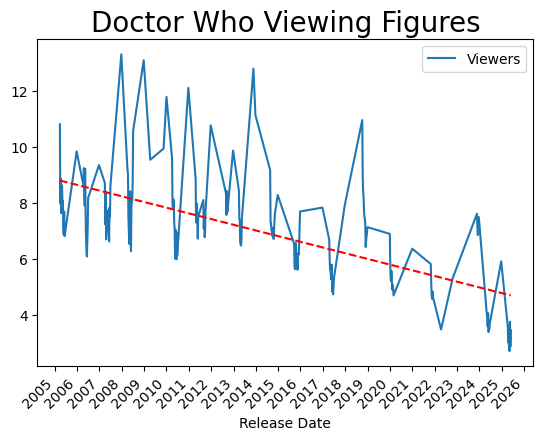

In [49]:

ax = (df2.plot())

# Set title
plt.title('Doctor Who Viewing Figures', fontsize=20)

# Create a linear trendline
x = mdates.date2num(df2.index)  # Convert datetime index to numeric
y = df2['Viewers'].values
z = np.polyfit(x, y, 1)         # Fit a linear model
p = np.poly1d(z)
ax.plot(df2.index, p(x), "r--", label='Trendline')  # Add trendline to plot

# Format x-axis to show one year per tick
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Tick every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY

# Rotate labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


Next we plot the same range but overlay it with changes in Doctor - this was originally done as a continuous line which looked nicer but was misleading.

For example, there was a steady rising line between the end of 13's final season and 14's run which looked like 13's popularity suddenly increased exponentially.  

Broken lines don't look as pretty but are more accurate


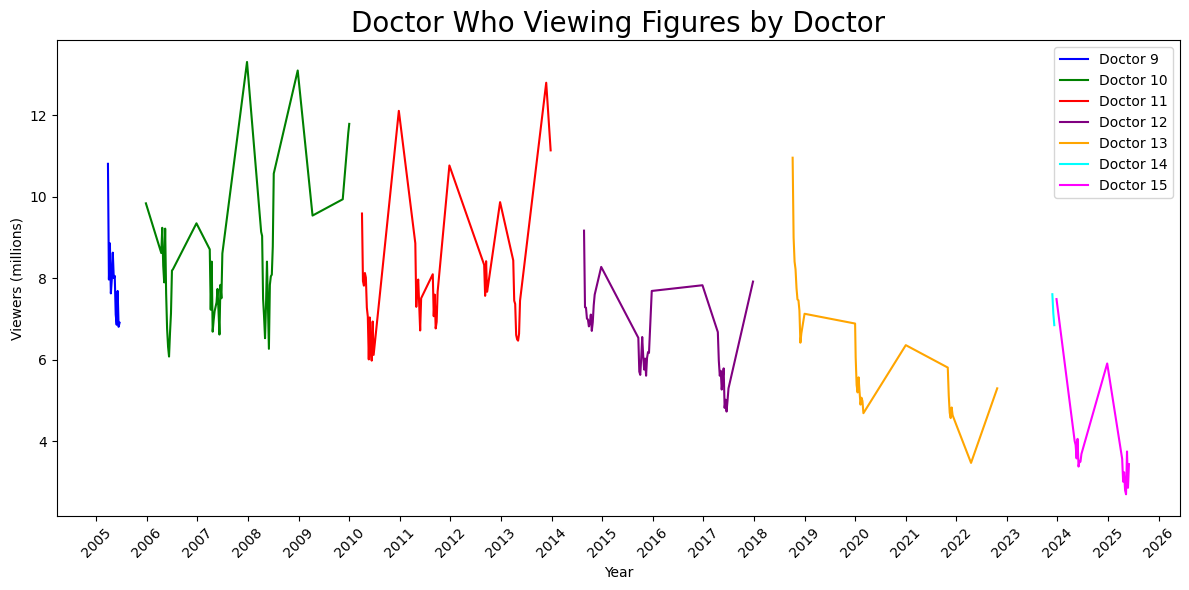

In [50]:
# Sort by date
df = df.sort_values(by='Release Date')

# Set up plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define color map
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black']
unique_doctors = df['Doctor'].unique()

# Plot each Doctor's episodes in a different color
for i, doctor in enumerate(unique_doctors):
    doctor_df = df[df['Doctor'] == doctor]
    ax.plot(doctor_df['Release Date'], doctor_df['Viewers'], label=f'Doctor {doctor}', color=colors[i % len(colors)])

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add labels and legend
plt.title('Doctor Who Viewing Figures by Doctor', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Viewers (millions)')
plt.legend()
plt.tight_layout()
plt.show()


We're seeing here at first glance that changes in Doctor do appear to affect viewing figures - not always for the better. Capaldi's debut (unfairly) caused a slump that the show didn't really recover from. 

Notice the huge spike between 12 and 13 - this can no doubt be attributed to the debut of the first female Doctor, a historic momemt that led to a rise in casual viewers, either seeing this as a feminist triumph or an opportunity to rage-watch and complain about WOKE. Viewers tailed off again dramatically in the weeks following when they realised they didn't like the show anyway.

The code was tweaked to show changes in Companion - this isn't used in the project so far but could be in the next iteration

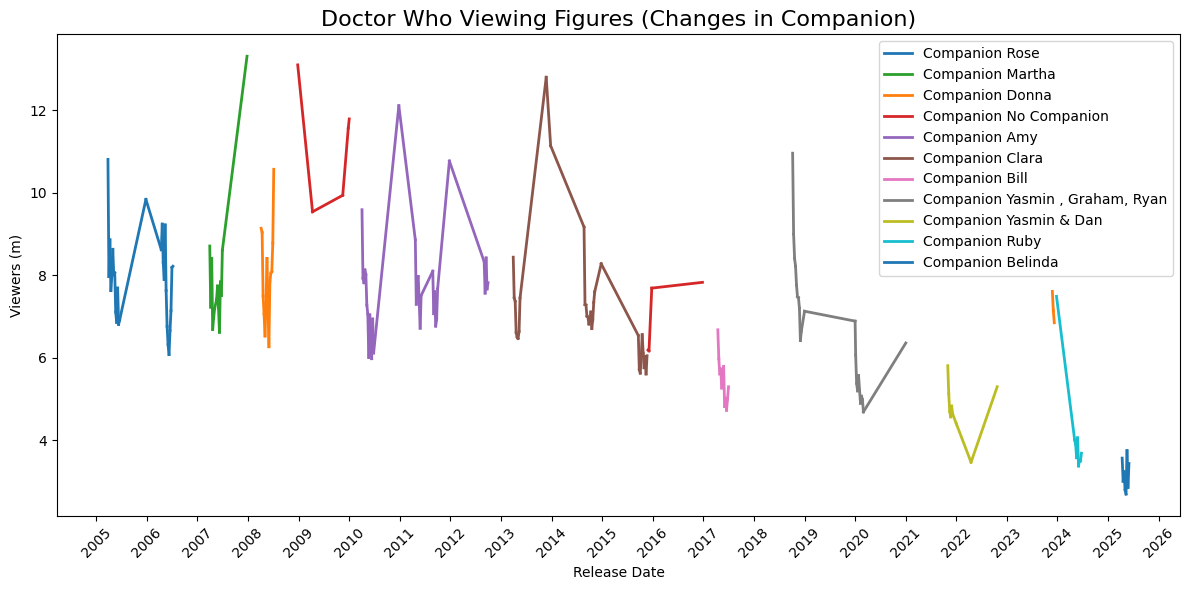

In [51]:
#Colour coded chart showing changes in Companion

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Track which companions have been added to the legend
plotted_companions = set()

# Create a mapping of companions to color indices
unique_companions = df['Companion'].unique()
companion_colors = {name: f"C{i % 10}" for i, name in enumerate(unique_companions)}

# Iterate through the data and plot segments between episodes
for i in range(len(df) - 1):
    current = df.iloc[i]
    next_row = df.iloc[i + 1]

    # Only draw line if companion is the same
    if current['Companion'] == next_row['Companion']:
        companion = current['Companion']
        color = companion_colors[companion]

        # Assign label only once per companion
        if companion not in plotted_companions:
            label = f"Companion {companion}"
            plotted_companions.add(companion)
        else:
            label = "_nolegend_"  # Prevents duplicate legend entries

        # Plot a line segment between current and next episode
        ax.plot([current['Release Date'], next_row['Release Date']],
                [current['Viewers'], next_row['Viewers']],
                color=color,
                linewidth=2,
                label=label)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add labels and title
plt.title('Doctor Who Viewing Figures (Changes in Companion)', fontsize=16)
plt.xlabel('Release Date')
plt.ylabel('Viewers (m)')

plt.tight_layout()
plt.legend()
plt.show()


And finally Showrunner

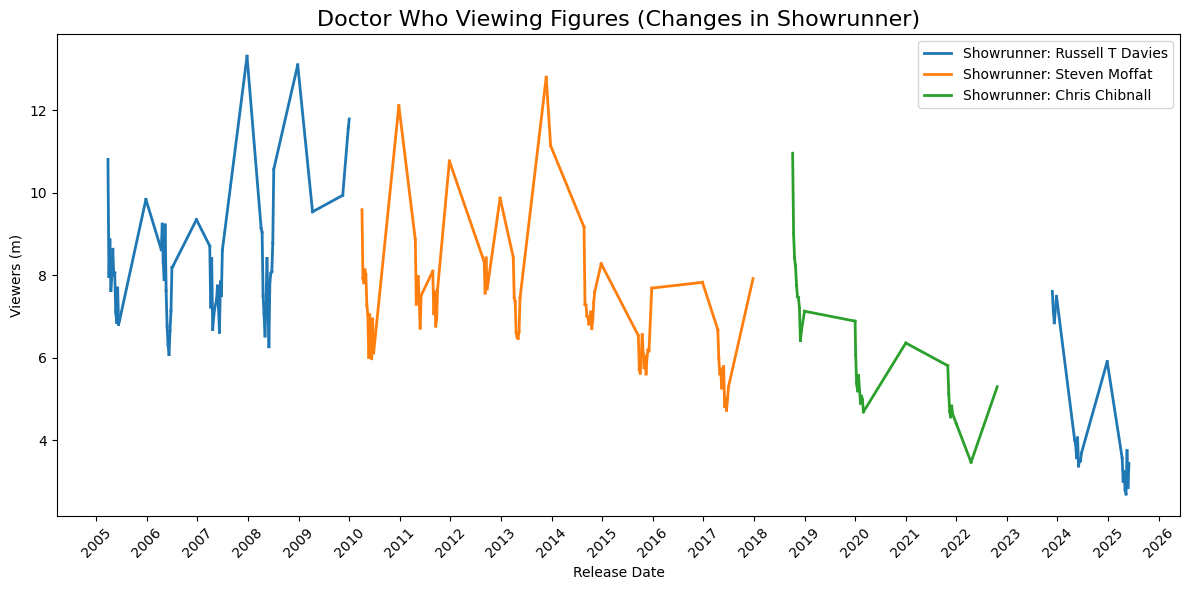

In [52]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Track which showrunners have been added to the legend
plotted_showrunners = set()

# Create a mapping of showrunners to color indices
unique_showrunners = df['Showrunner'].unique()
showrunner_colors = {name: f"C{i % 10}" for i, name in enumerate(unique_showrunners)}

# Iterate through the data and plot segments between episodes
for i in range(len(df) - 1):
    current = df.iloc[i]
    next_row = df.iloc[i + 1]

    # Only draw line if showrunner is the same
    if current['Showrunner'] == next_row['Showrunner']:
        showrunner = current['Showrunner']
        color = showrunner_colors[showrunner]

        # Assign label only once per showrunner
        if showrunner not in plotted_showrunners:
            label = f"Showrunner: {showrunner}"
            plotted_showrunners.add(showrunner)
        else:
            label = "_nolegend_"

        # Plot the line segment
        ax.plot([current['Release Date'], next_row['Release Date']],
                [current['Viewers'], next_row['Viewers']],
                color=color,
                linewidth=2,
                label=label)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add labels and title
plt.title('Doctor Who Viewing Figures (Changes in Showrunner)', fontsize=16)
plt.xlabel('Release Date')
plt.ylabel('Viewers (m)')

plt.tight_layout()
plt.legend()
plt.show()


---

Next we use `loc[]` functionality to drill down into any particular areas of interest and investigate further

For example, here we just looked at two years and changed the formatting which show viewing spikes in December that can be investigated further

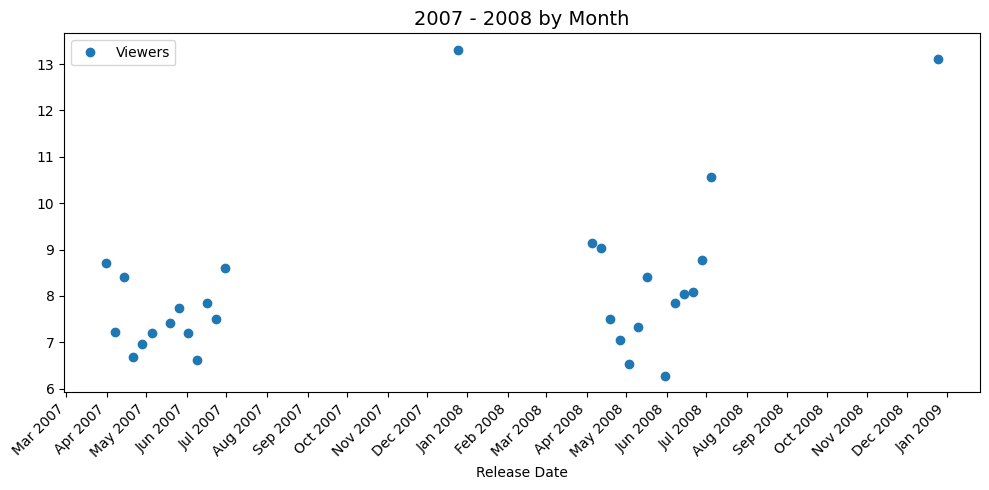

In [53]:
# loc is Label-based indexing

# Plot the data as dots
ax = df2.loc['2007':'2008'].plot(style='o', figsize=(10, 5))  # 'o' means circle markers


# Set major ticks to every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Format ticks to show abbreviated month and year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate labels for readability
plt.xticks(rotation=45)

# Title and layout
plt.title("2007 - 2008 by Month", fontsize=14)
plt.tight_layout()
plt.show()



<a name="section_3"></a>
## 3. Trends


To identify underlying trends, first we create rolling monthly averages at four, six and twelve month intervals.


In [54]:
df2['4-MA'] =  df2['Viewers'].rolling(window=4,  center=True).mean()
df2['6-MA'] =  df2['Viewers'].rolling(window=6,  center=True).mean()
df2['12-MA'] = df2['Viewers'].rolling(window=12, center=True).mean()
df2.head(8)

,Viewers,4-MA,6-MA,12-MA
Release Date,,,,
2005-03-26,10.81,NaN,NaN,NaN
2005-04-02,7.97,NaN,NaN,NaN
2005-04-09,8.86,8.8175,NaN,NaN
2005-04-16,7.63,8.1100,8.646667,NaN
2005-04-23,7.98,8.2750,8.180000,NaN
2005-04-30,8.63,8.0625,8.195000,NaN
2005-05-07,8.01,8.1700,7.903333,8.035
2005-05-14,8.06,7.9525,7.775000,7.710


We then plot those new columns and give the different period moving averages their own style so that they stand out more clearly.

(array([12418., 13879., 15340., 16801., 18262., 19723., 21184.]),
 [Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024'),
  Text(21184.0, 0, '2028')])

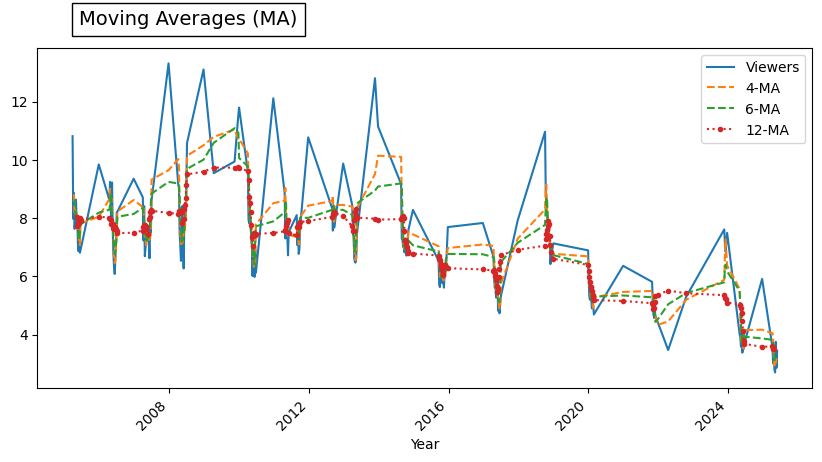

In [55]:

df2.plot(style=['-','--','--',':.'], figsize=(10,5))

# Use a numeric or datetime x-value that matches your data
plt.text(df2.index[10], df2.max().max() * 1.1,
         "Moving Averages (MA)",
         fontsize=14,
         bbox=dict(facecolor='white', edgecolor='black', pad=5))

plt.xlabel('Year', fontsize=10)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

Below we remove the 12 MA trend by subtracting it from the original time series

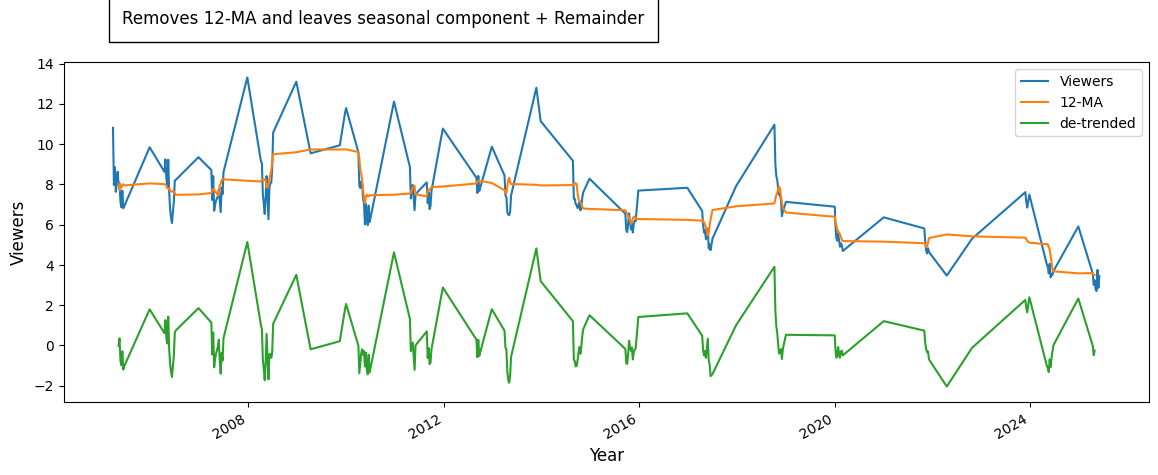

In [56]:
df2['de-trended'] = df2['Viewers'] - df2['12-MA']

df2[['Viewers','12-MA','de-trended']].plot(figsize=(14,5));

plt.text(df2.index[10], df2.max().max() * 1.2,
    """Removes 12-MA and leaves seasonal component + Remainder""", 
    fontsize = 12, bbox=dict(facecolor='white', edgecolor='black', pad=10))
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Viewers', fontsize = 12);

<a name="section_4"></a>
## 4. Seasonality


Next we take away the shifted data to remove the seasonality, this is known as *seasonal differencing*



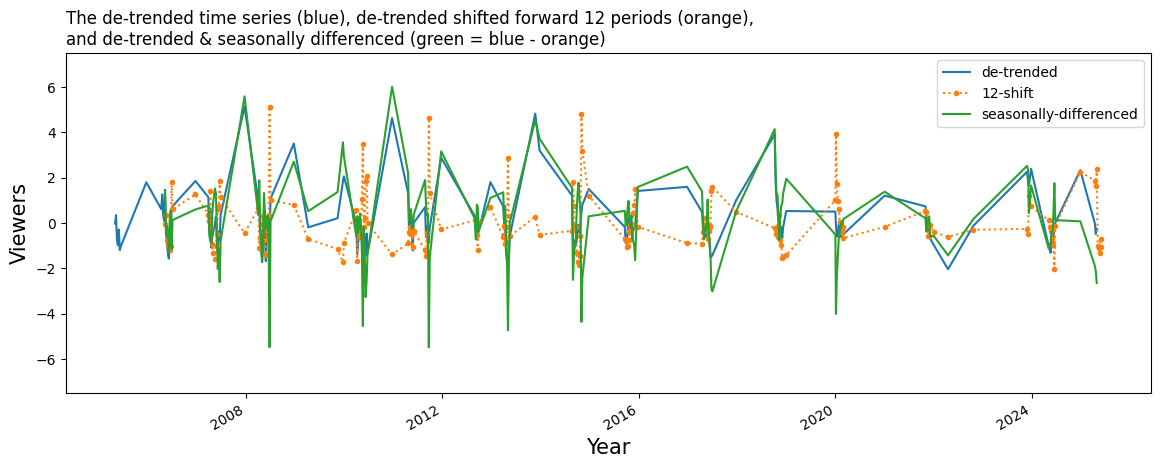

In [57]:
df2['12-shift'] = df2['de-trended'].shift(periods=12)

df2['seasonally-differenced'] = df2['de-trended']- df2['12-shift']

df2[['de-trended', '12-shift', 'seasonally-differenced']].plot(style=['-', ':.'],figsize=(14,5))

plt.title("""The de-trended time series (blue), de-trended shifted forward 12 periods (orange),
and de-trended & seasonally differenced (green = blue - orange)""", fontsize=12, loc='left')
plt.ylim(-7.5,7.5)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Viewers', fontsize=15);

We can calculate the correlation co-efficient between the de-trended series and its 12-lag values as follows.

In [58]:
df2['de-trended'].corr(df2['12-shift']).round(2)

np.float64(0.0)

We can see that there is a zero correlation between detrended series and its 12-lag values so no seasonality.

Below shows the actual values of the 12 lags

In [59]:
for shift in range(1,13):
    print(shift,':',df2['de-trended'].corr(df2['de-trended'].shift(shift)).round(2))

1 : 0.41
2 : 0.03
3 : -0.15
4 : -0.31
5 : -0.32
6 : -0.24
7 : -0.08
8 : -0.09
9 : -0.01
10 : 0.01
11 : -0.03
12 : 0.0


**Auto-Correlation Function (ACF)** looks at how strongly a time series is correlated with its past value at different lags.

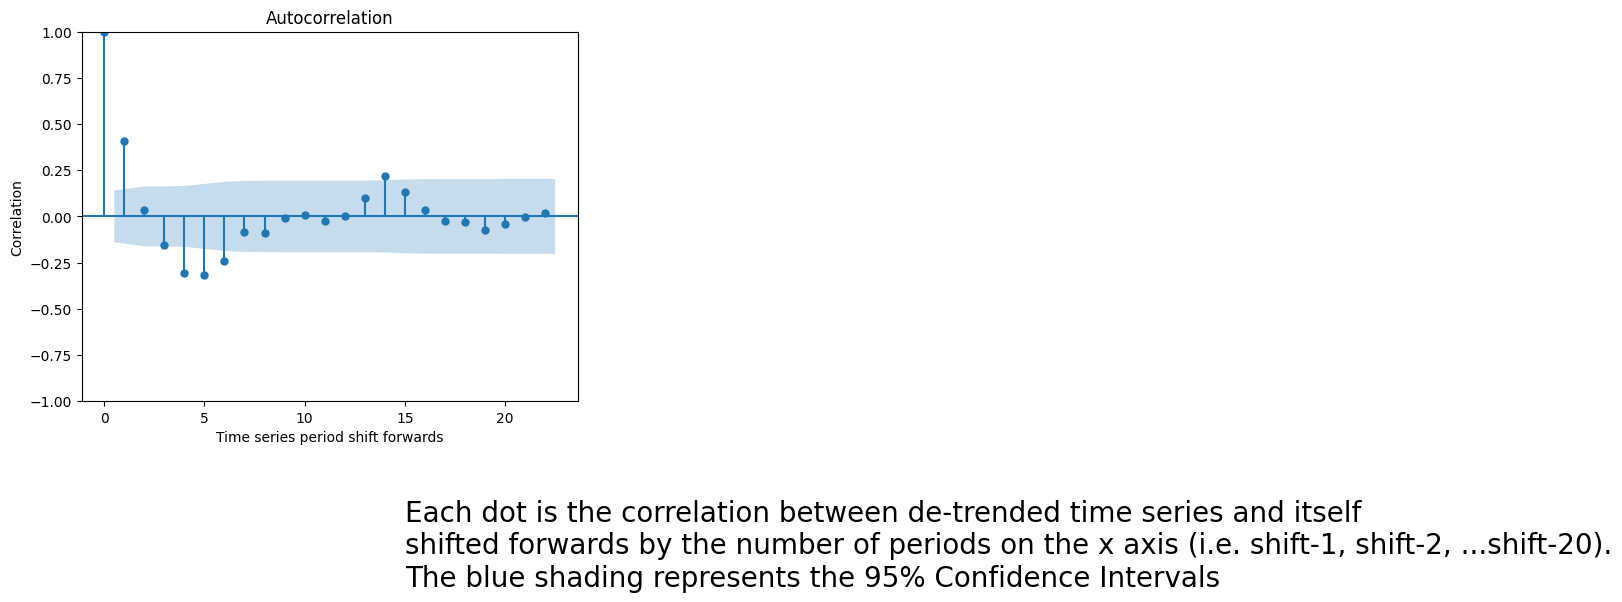

In [60]:
from statsmodels.graphics import tsaplots

tsaplots.plot_acf(df2['de-trended'],missing='drop',lags=22,alpha=0.05)

plt.xlabel('Time series period shift forwards')
plt.ylabel('Correlation')

plt.text(15,-2,"""Each dot is the correlation between de-trended time series and itself
shifted forwards by the number of periods on the x axis (i.e. shift-1, shift-2, ...shift-20).
The blue shading represents the 95% Confidence Intervals""", fontsize = 20);

---

<a name="section_5"></a>
## 5. De-composition


We can use the statsmodels function to automatically perform the decomposition

`statsmodels.tsa.seasonal.seasonal_decompose()` 



First we have to create the df2 dataframe again to remove all the MA fields

In [61]:
df2 = df[['Release Date','Viewers',]].copy()

# Group data by 
aggregated_df2 = df2.groupby(['Release Date']).sum('Viewers')
df2 = aggregated_df2

df2.shape


(196, 1)

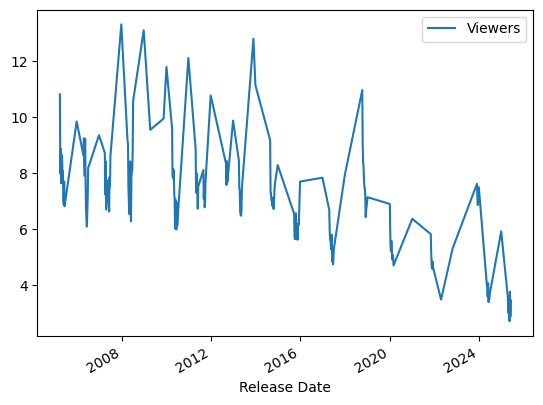

In [62]:
# df2 = aggregated_df2
df2.plot();

And then we perform the `seasonal_decompose()` function using `model='multiplicative'` so we can see the distance between the peaks and troughs of the time

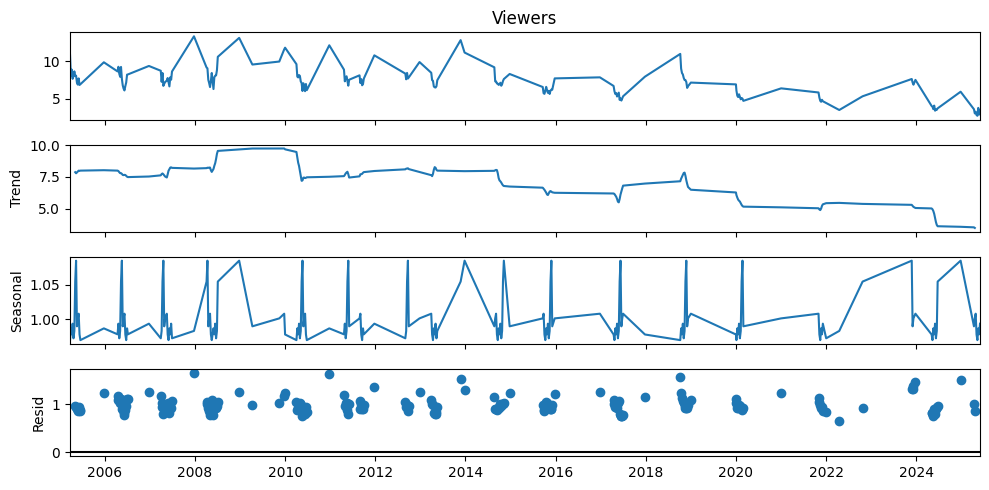

In [63]:
decomp=sm.tsa.seasonal_decompose(df2['Viewers'], model='multiplicative', period=12)
fig = decomp.plot()
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

What does this show us?

**Trend:** there is an downwards trend over time.

**Seasonality:** there is no strong seasonal pattern, however, there does appear to be cyclical elements at play from the Specials.
   
Although we have a trend, the lack of seasonality means this is not a good candidate for **time series forecasting** using **Error Trend & Seasonality (ETS)** which was the intention for the next part of this project
 

<a name="section_6"></a>
## 6. Forecast

As an alternative to **ETS**, instead I've switched the forecast element of this to **Exponential Smoothing**

Unfortunately the forecast predicts that worse ratings await the show over the next two years if the showrunners continue with their current trajectory

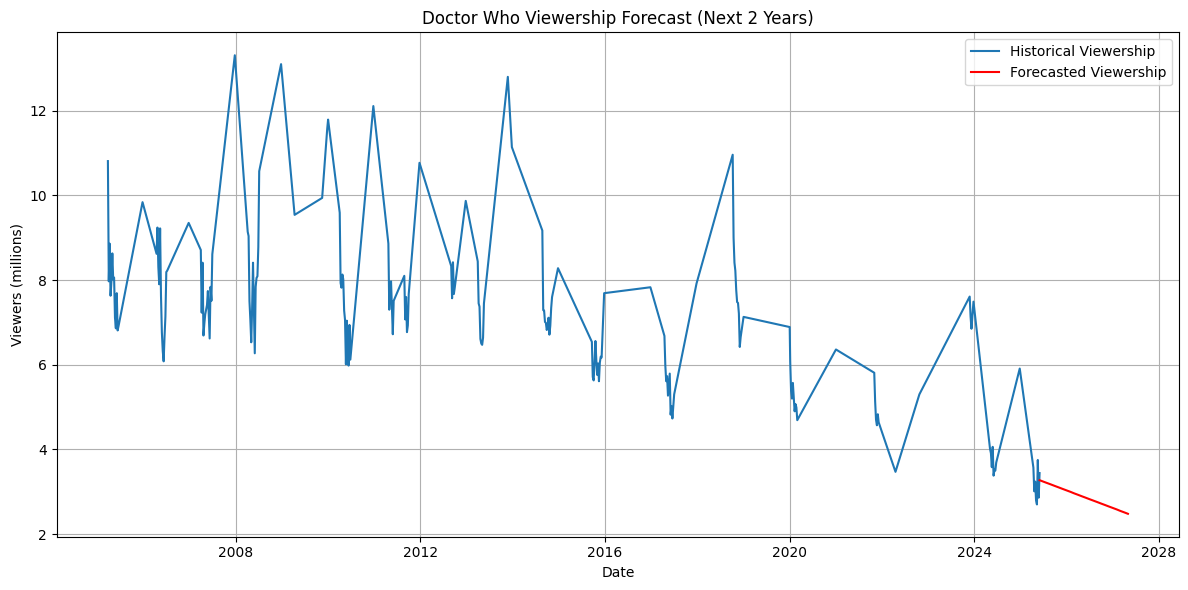

In [64]:

# Fit Exponential Smoothing model with warnings suppressed - the warnings being supressed are just related to the date indexing and are a result of the irregularity of episodes
#They don't affect the trend or the forecast
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model = ExponentialSmoothing(df2['Viewers'], trend='add', seasonal=None, initialization_method="estimated")
    fit = model.fit(optimized=True)
    forecast = fit.forecast(steps=24)

# Clip negative values to zero
forecast = forecast.clip(lower=0)

# Generate future dates starting from the last known release date
future_dates = pd.date_range(start=df2.index[-1], periods=24, freq='ME')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df2.index, df2['Viewers'], label='Historical Viewership')
plt.plot(future_dates, forecast, label='Forecasted Viewership', color='red')
plt.title('Doctor Who Viewership Forecast (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Viewers (millions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We saw in the EDA though that changes in Doctor can boost ratings - Tennant taking over from Ecclestone saw a signifiant boost as did his return as 14 -so maybe the next regeneration will see the show return to better fortunes.

Especially if it's Billie Piper 😂



<a name="section_6"></a>
## 7. Regression

In order to address the hypothesis that change in Doctor will cause a shift of 1m viewers, regression testing was used.

Although the coefficient showed an average increase of 1.17m which would suggest the hypothesis was accurate, the P Number is only 0.063 so the change is unlikely to be down to a change in the Doctor

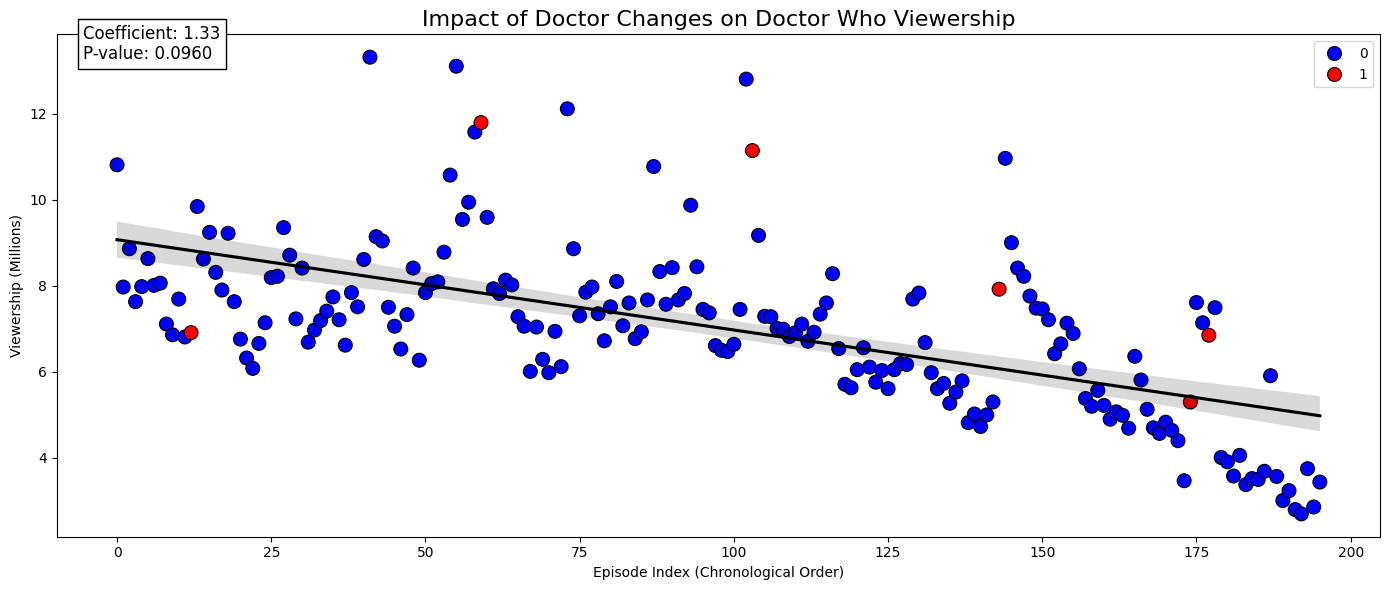

In [ ]:
# Create a binary variable indicating a change in Doctor
df['Doctor Change'] = (df['Doctor'] != df['Doctor'].shift()).astype(int)
df['Doctor Change'] = df['Doctor Change'].shift(-1).fillna(0).astype(int)

# Drop rows with missing viewership data
df = df.dropna(subset=['Viewers'])

# Define independent (X) and dependent (y) variables
X = df[['Doctor Change']]
X = sm.add_constant(X)  # add intercept
y = df['Viewers']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Extract coefficient and p-value
coef = model.params['Doctor Change']
p_value = model.pvalues['Doctor Change']

# Create the plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df, x=df.index, y='Viewers', hue='Doctor Change',
                palette={0: 'blue', 1: 'red'}, legend='full', s=100, edgecolor='black')
sns.regplot(data=df, x=df.index, y='Viewers', scatter=False, color='black',
            line_kws={"label": "Regression Line"})

# Annotate with regression results
plt.text(0.02, 0.95, f"Coefficient: {coef:.2f}\nP-value: {p_value:.4f}",
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(facecolor='white', edgecolor='black'))

# Customize plot
plt.title("Impact of Doctor Changes on Doctor Who Viewership", fontsize=16)
plt.xlabel("Episode Index (Chronological Order)")
plt.ylabel("Viewership (Millions)")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("doctor_change_viewership_plot.png")
plt.show()

# Interpretation
if p_value < 0.05:
    display(HTML("<p style='font-size:24px; color:white;'>Conclusion: A change in the Doctor is significantly associated with a change in viewership.</p>"))
else:
    display(HTML("<p style='font-size:24px; color:white;'>Conclusion: There is no statistically significant relationship between Doctor changes and viewership.</p>"))

